In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import keras

import bayesflow as bf

2024-07-21 14:38:24.654378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setup

In [3]:
two_moons = bf.benchmarks.TwoMoons()

In [4]:
num_train_simulations = 2048
num_val_simulations = 300
batch_size = 256
epochs = 1000

In [5]:
train_dataset = bf.datasets.OfflineDataset(two_moons.sample(num_train_simulations), batch_size=batch_size)
val_dataset = bf.datasets.OfflineDataset(two_moons.sample(num_val_simulations), batch_size=100)

In [6]:
inference_network = bf.networks.FlowMatching(subnet='mlp', subnet_kwargs=dict(depth=6))

approximator = bf.Approximator(
    inference_network=inference_network,
    inference_variables=["parameters"],
    inference_conditions=["observables"],
)

In [7]:
learning_rate = keras.optimizers.schedules.CosineDecay(1e-3, epochs * train_dataset.num_batches, 1e-6)

In [8]:
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate,
    global_clipnorm=1.0,
)

In [9]:
approximator.compile(optimizer=optimizer)

## Training

In [10]:
fit_history = approximator.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 1.0254 - val_loss: 0.6105
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5873 - val_loss: 0.5488
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4907 - val_loss: 0.4088
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4574 - val_loss: 0.4084
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4426 - val_loss: 0.4141
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4486 - val_loss: 0.3686
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4315 - val_loss: 0.4440
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4658 - val_loss: 0.3702
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4580 - val_loss: 0.3956
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4457 - val_loss: 0.4052
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4436 - val_loss: 0.4212
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3

KeyboardInterrupt: 

In [11]:
## Plot losses

## Validation

AttributeError: Exception encountered when calling FlowMatching.call().

[1mmodule 'keras.ops' has no attribute 'dtype'[0m

Arguments received by FlowMatching.call():
  • xz=tf.Tensor(shape=(1, 5000, 2), dtype=float32)
  • conditions=tf.Tensor(shape=(1, 5000, 2), dtype=float32)
  • inverse=True
  • kwargs={'density': 'False'}

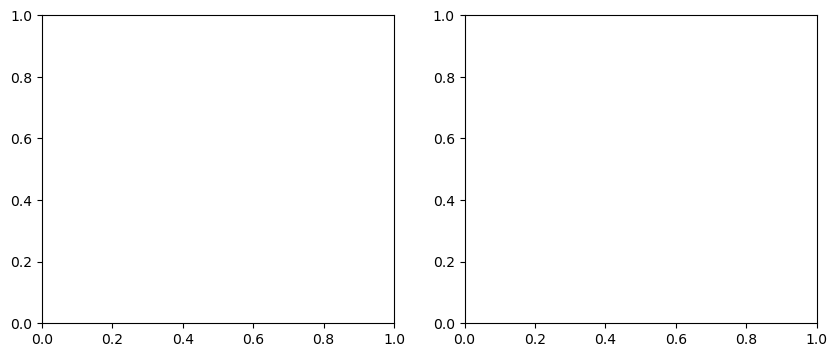

In [13]:
# Set the number of posterior draws you want to get
num_samples = 5000

# Prepare figure
f, axarr = plt.subplots(1, 2, figsize=(10, 4))

# Obtain amortized samples
obs_data = np.zeros((1, 2)).astype(np.float32)
samples = approximator.sample(num_samples=num_samples, data={"observables": obs_data}, numpy=True)

# Plot samples
axarr[0].scatter(samples["parameters"][:, 0], samples["parameters"][:, 1], color="maroon", alpha=0.75, s=0.5)
sns.despine(ax=axarr[0])
axarr[0].set_title(r"Posterior samples at $x=(0, 0)$")
axarr[0].grid(alpha=0.3)
axarr[0].set_xlim([-0.5, 0.5])
axarr[0].set_ylim([-0.5, 0.5])

# Compute log density on relevant posterior range
side = np.linspace(-0.5, 0.5, 100)
x, y = np.meshgrid(side, side)
obs_data_rep = np.zeros((10000, 2)).astype(np.float32)
params = np.c_[x.flatten(), y.flatten()]
lpdf = inference_network.log_prob(params, obs_data_rep)

# # Plot the density map using nearest-neighbor interpolation
axarr[1].pcolormesh(x, y, np.exp(lpdf).reshape(100, 100), cmap=cm.hot)
axarr[1].set_title(r"Posterior density at $x=(0, 0)$")

f.tight_layout()